In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import xarray as xr
import pandas as pd
import numpy as np
import scipy.io as io

from tqdm import tqdm_notebook as tqdm
import datashader as ds
import datashader.transfer_functions as tf
from collections import OrderedDict
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
from deepflow.plotting_utils import create_simulation_time_axis, colorbar, extract_min_misfits, load_folders
from deepflow.plotting_utils import get_unconditionals, plot_row_curves, plot_row_envelopes
from deepflow.plotting_utils import determine_connected

## Setting parameters for importing and plotting

In [3]:
plot = False
working_dir = './results/runs/'
perm = "low_perm"

#Creates the simulation time axis
dts = create_simulation_time_axis()

#Load the ground truth case from the test set, corresponds to test set model 67
gt = np.load("./results/model_67_x.npy")
envelope = gt[0, :, ::-1].T

In [4]:
ds_ref = xr.open_dataset(working_dir+perm+'/reference/reference.nc')
qor_ref = ds_ref['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24)
qwr_ref = ds_ref['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24)
p_ref = ds_ref['state_variables'][dict(state_variable=0, well=0)]/1e5

ref_curves = [qor_ref, qwr_ref, p_ref]

## Loading Unconditional Prior Pressure, Rate and Property Distribution Data|

In [5]:
unc_curves, unc_poros, unc_perms, unc_zs, unc_misfits = get_unconditionals('./results/runs/', perm)

99
199
299
399
499
599
699
799
899
999


In [6]:
unc_props = np.concatenate([unc_poros.reshape(1000, 1, 64, 128), unc_perms.reshape(1000, 1, 64, 128)], 1)

## Loading the optimized samples for each inversion case: wells, flow, and flow+wells

In [7]:
folders = [perm+a for a in ["/wells_adam_gauss", "/flow_adam_gauss", "/flowwells_adam_gauss"]]
all_curves, all_poroperms, all_zs = load_folders("./results/runs/", folders)

In [8]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

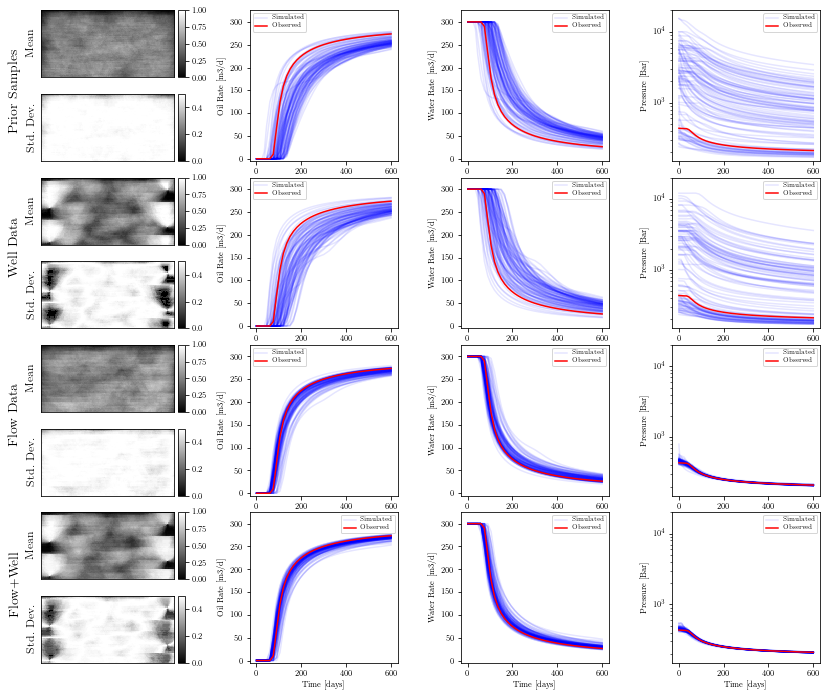

In [9]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.25)
plot_row_curves(0, unc_props[0:100], unc_curves[0:100], ref_curves, dts, desc="Prior Samples")
plot_row_curves(2, all_poroperms[0][0], all_curves[0][0], ref_curves, dts, desc="Well Data")
plot_row_curves(4, all_poroperms[1][0], all_curves[1][0], ref_curves, dts, desc="Flow Data")
plot_row_curves(6, all_poroperms[2][0], all_curves[2][0], ref_curves, dts, desc="Flow+Well")
if plot:
    plt.savefig("./results/figures/all_runs.png", dpi=300, bbox_inches="tight")

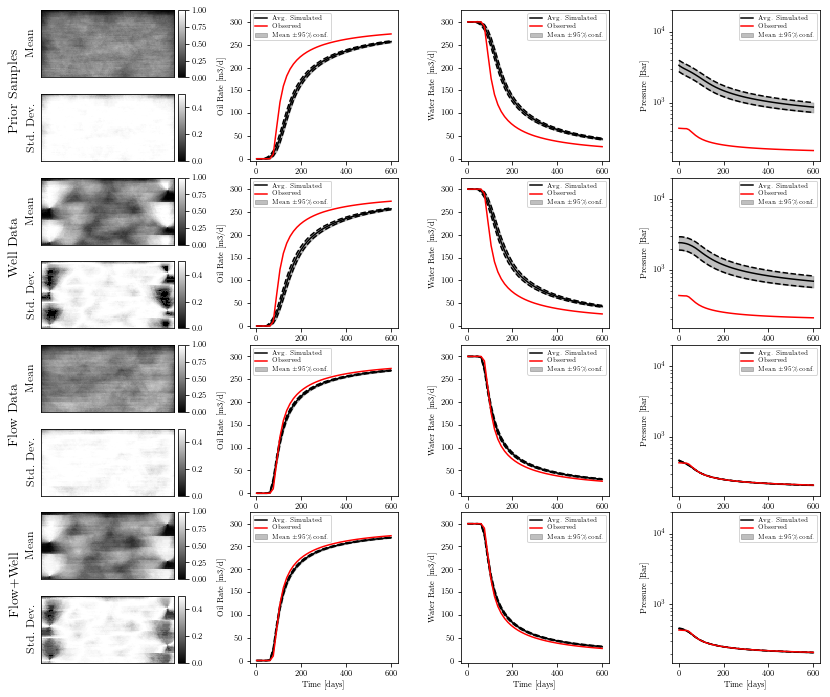

In [10]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.25)
plot_row_envelopes(0, unc_props[0:100], unc_curves[0:100], ref_curves, dts, desc="Prior Samples")
plot_row_envelopes(2, all_poroperms[0][0], all_curves[0][0], ref_curves, dts, desc="Well Data")
plot_row_envelopes(4, all_poroperms[1][0], all_curves[1][0], ref_curves, dts, desc="Flow Data")
plot_row_envelopes(6, all_poroperms[2][0], all_curves[2][0], ref_curves, dts, desc="Flow+Well")
if plot:
    plt.savefig("./results/figures/all_runs_envelopes.png", dpi=300, bbox_inches="tight")

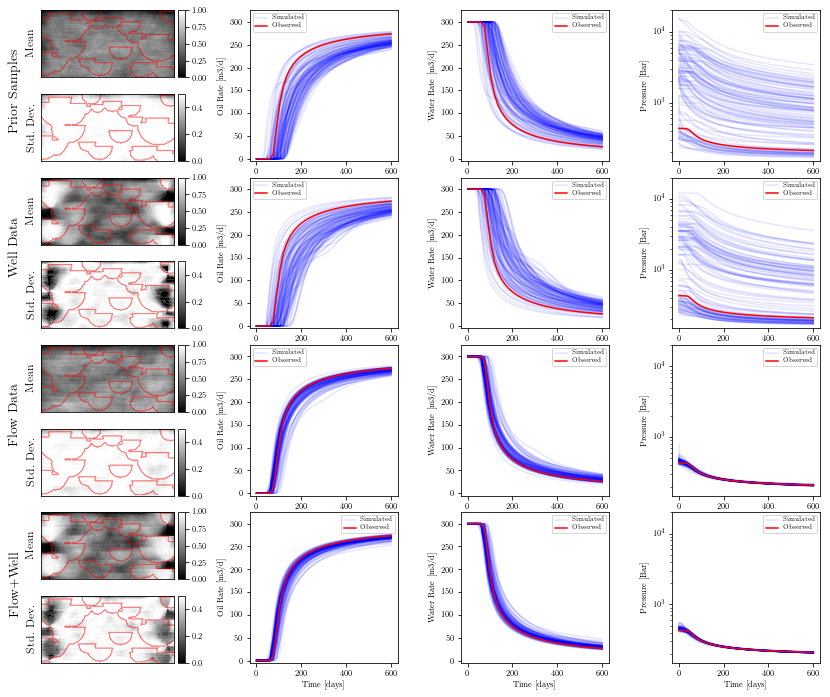

In [11]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.25)
plot_row_curves(0, unc_props[0:100], unc_curves[0:100], ref_curves, dts, envelope,  desc="Prior Samples")
plot_row_curves(2, all_poroperms[0][0], all_curves[0][0], ref_curves, dts, envelope, desc="Well Data")
plot_row_curves(4, all_poroperms[1][0], all_curves[1][0], ref_curves, dts, envelope, desc="Flow Data")
plot_row_curves(6, all_poroperms[2][0], all_curves[2][0], ref_curves, dts, envelope, desc="Flow+Well")
if plot:
    plt.savefig("./results/figures/all_runs_gt.png", dpi=300, bbox_inches="tight")

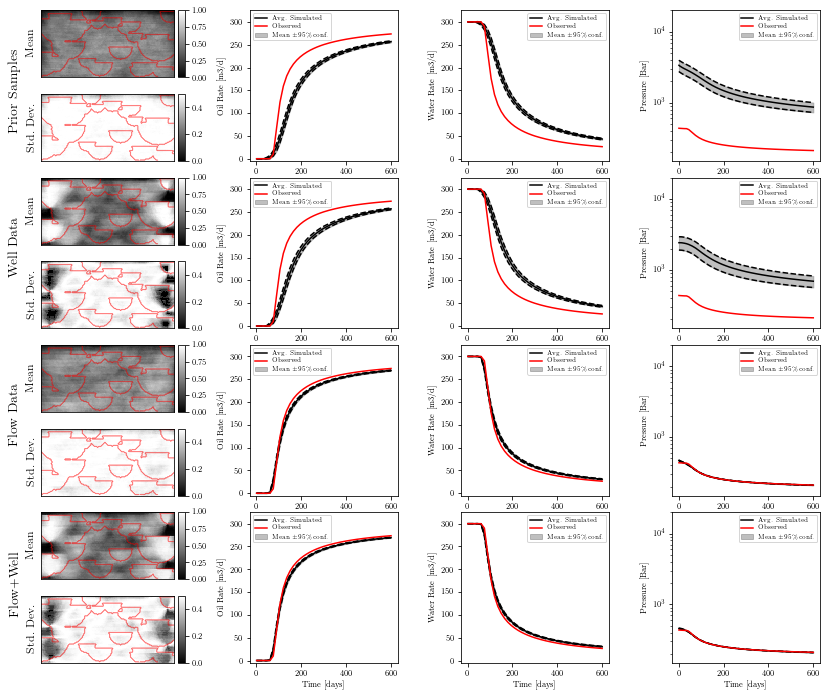

In [12]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.25)
plot_row_envelopes(0, unc_props[0:100], unc_curves[0:100], ref_curves, dts, envelope, desc="Prior Samples")
plot_row_envelopes(2, all_poroperms[0][0], all_curves[0][0],  ref_curves, dts, envelope, desc="Well Data")
plot_row_envelopes(4, all_poroperms[1][0], all_curves[1][0],  ref_curves, dts, envelope, desc="Flow Data")
plot_row_envelopes(6, all_poroperms[2][0], all_curves[2][0],  ref_curves, dts, envelope, desc="Flow+Well")
if plot:
    plt.savefig("./results/figures/all_runs_envelopes.png", dpi=300, bbox_inches="tight")

In [14]:
def inverse_permeability_transform(x, a=0.001, b=1e-12):
    return x/b-a

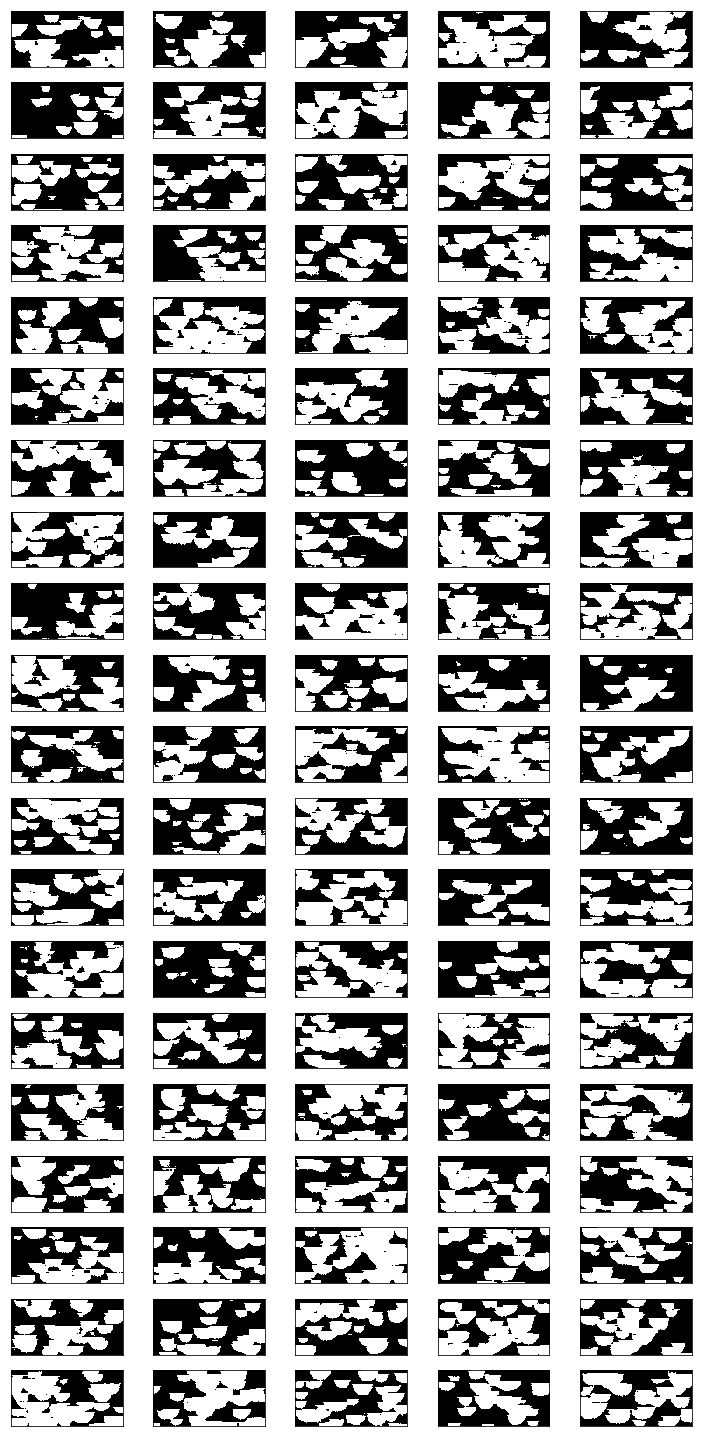

In [25]:
fig, ax = plt.subplots(20, 5, figsize=(10, 20))
plot = [np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in unc_props[0:100]]

for a, im in zip(ax.flatten(), plot):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if True:
    plt.savefig("./results/figures/unconditional_samples.png", dpi=300, bbox_inches="tight")

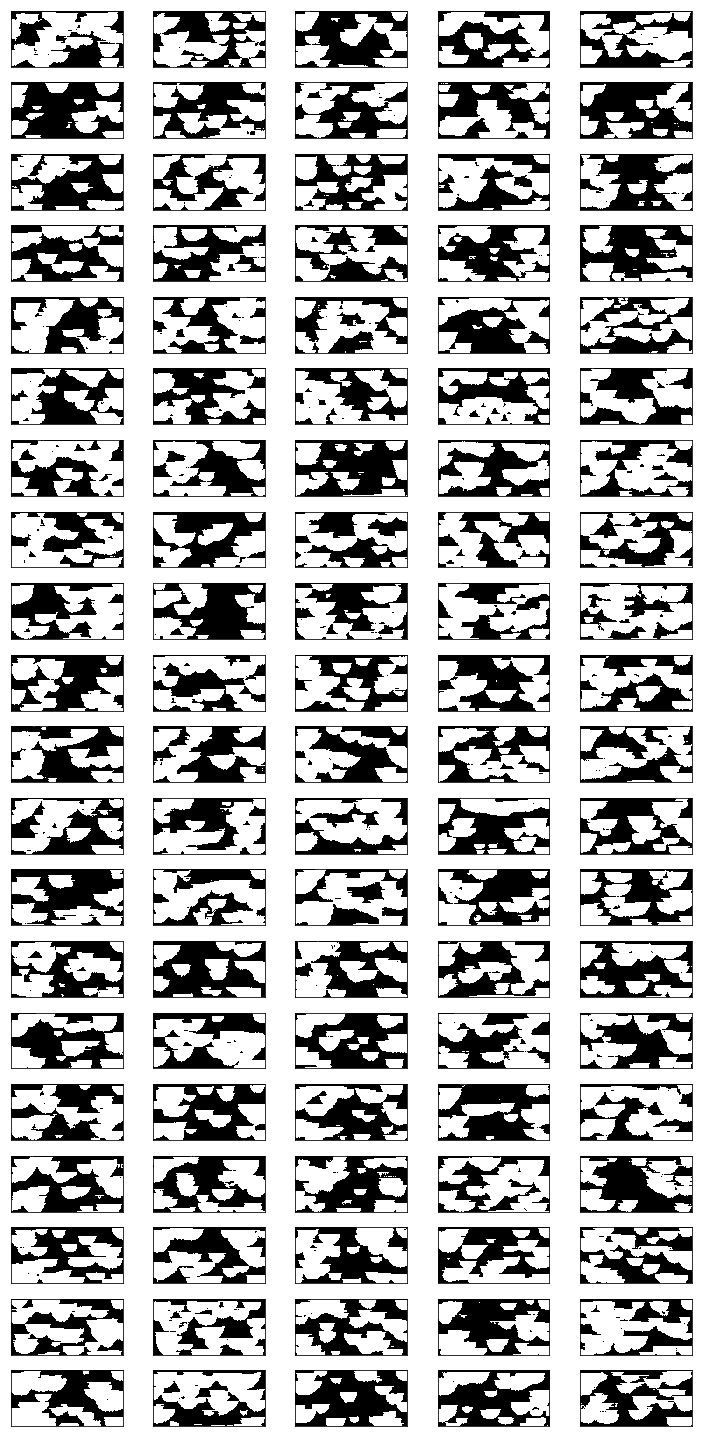

In [26]:
fig, ax = plt.subplots(20, 5, figsize=(10, 20))
plot = [np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in all_poroperms[0][0]]

for a, im in zip(ax.flatten(), plot):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if True:
    plt.savefig("./results/figures/wells_samples.png", dpi=300, bbox_inches="tight")

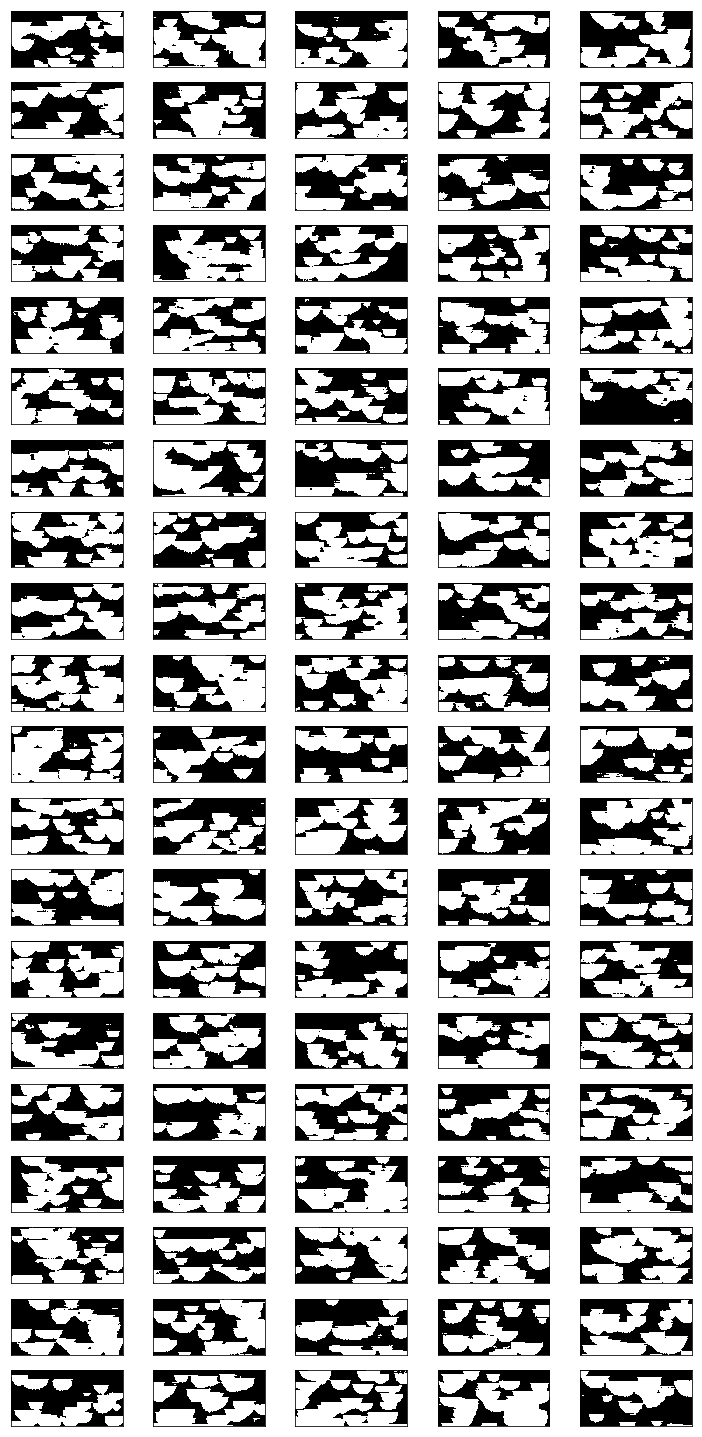

In [27]:
fig, ax = plt.subplots(20, 5, figsize=(10, 20))
plot = [np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in all_poroperms[1][0]]

for a, im in zip(ax.flatten(), plot):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if True:
    plt.savefig("./results/figures/flow_samples.png", dpi=300, bbox_inches="tight")

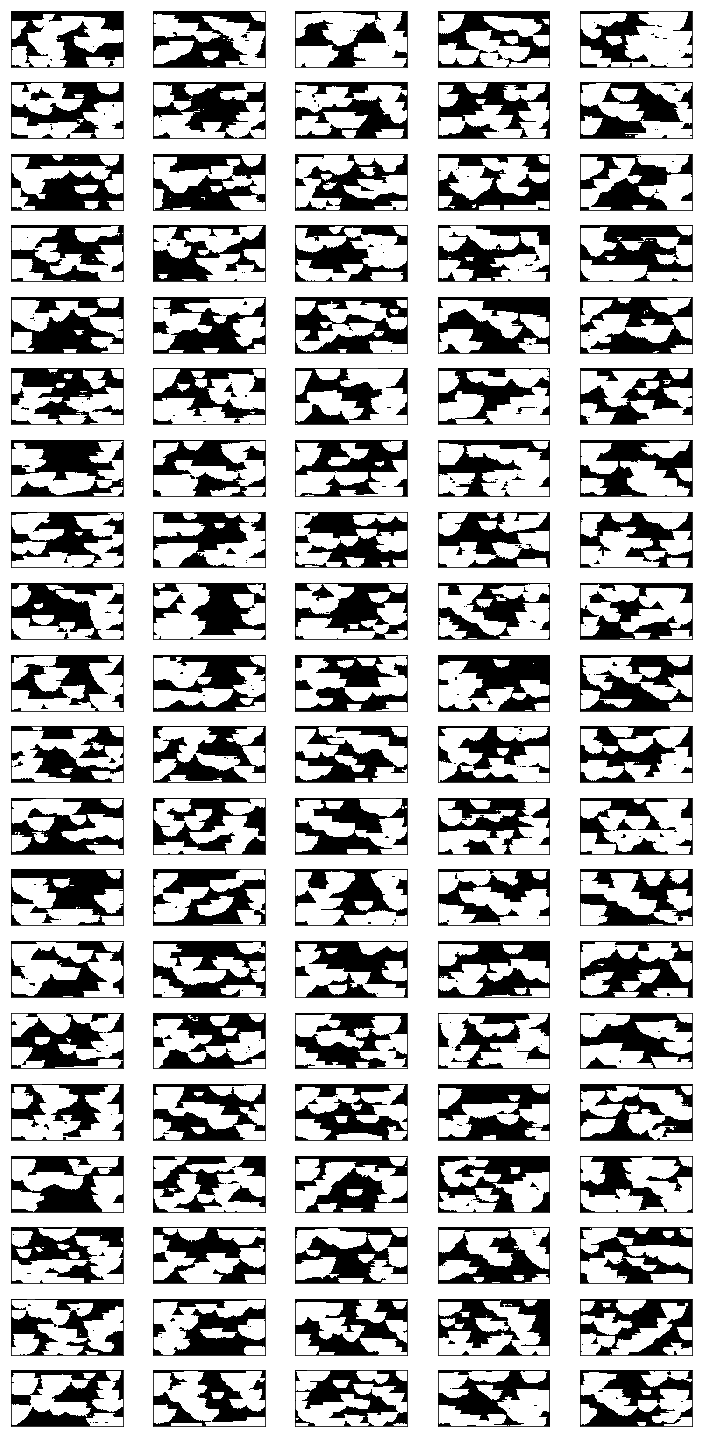

In [28]:
fig, ax = plt.subplots(20, 5, figsize=(10, 20))
plot = [np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in all_poroperms[2][0]]

for a, im in zip(ax.flatten(), plot):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if True:
    plt.savefig("./results/figures/flowwells_samples.png", dpi=300, bbox_inches="tight")

### Experimental

True
0.51989746


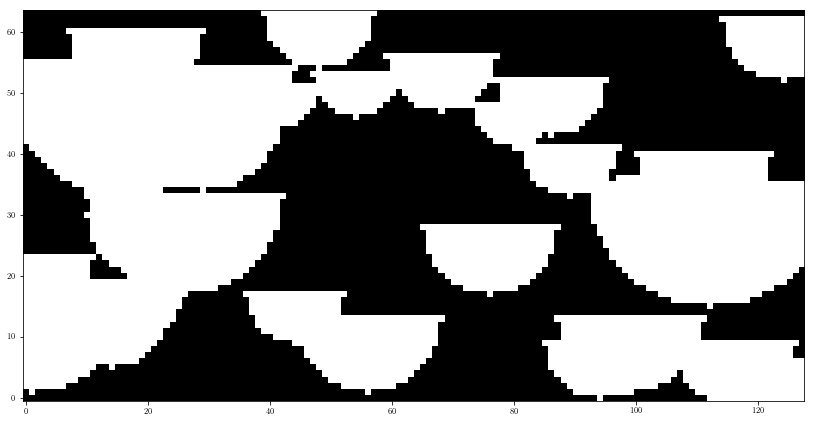

In [39]:
plt.imshow(envelope)
print(determine_connected(envelope))
print(np.sum(envelope/(128*64)))

In [28]:
for x in [connected_facies_unc, connected_facies_wells, connected_facies_flow, connected_facies_flow_wells]:
    _, counts = np.unique(x, return_counts=True)
    print(counts)

[74 26]
[60 40]
[ 7 93]
[ 7 93]


In [29]:
ntg_facies_unc = [np.sum(np.where(poro_perm[1]>1e-13, 1, 0)[::-1])/(128*64) for poro_perm in unc_props] 
ntg_facies_wells = [np.sum(np.where(poro_perm[1]>1e-13, 1, 0)[::-1])/(128*64) for poro_perm in all_poroperms[0][0]] 
ntg_facies_flow = [np.sum(np.where(poro_perm[1]>1e-13, 1, 0)[::-1])/(128*64) for poro_perm in all_poroperms[1][0]] 
ntg_facies_flow_wells = [np.sum(np.where(poro_perm[1]>1e-13, 1, 0)[::-1])/(128*64) for poro_perm in all_poroperms[2][0]] 

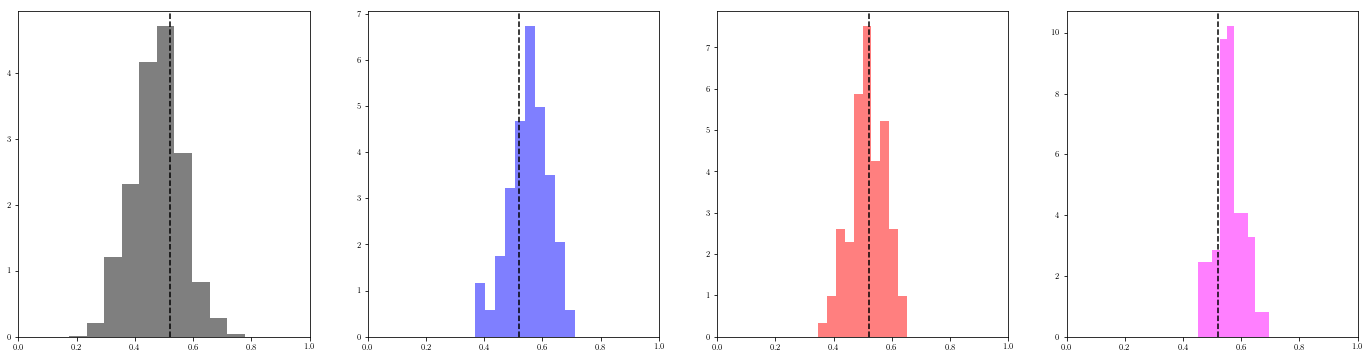

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(6*4, 6))
ax[0].hist(np.array(ntg_facies_unc), color="black", alpha=0.5, normed=True)
ax[1].hist(np.array(ntg_facies_wells), color="blue", alpha=0.5, normed=True)
ax[2].hist(np.array(ntg_facies_flow), color="red", alpha=0.5, normed=True)
ax[3].hist(np.array(ntg_facies_flow_wells), color="magenta", alpha=0.5, normed=True)
for i in range(4):
    ax[i].set_xlim(0, 1.0)
    ax[i].axvline(0.51989, color="black", linestyle="--")

In [70]:
import torch
from deepflow.utils import set_seed
from deepflow.utils import load_generator

In [71]:
generator = load_generator("./checkpoints/generator_facies_multichannel_4_6790.pth")

In [89]:
pdf = torch.distributions.Normal(0, 1)

In [126]:
set_seed(42)
ks = []
for i in tqdm(range(100)):
    with torch.no_grad():
        z = pdf.sample((10, 50, 1, 2))
        k, poro, x = generator(z)
        ks.append(x.numpy())
ks = np.concatenate(ks, 0)

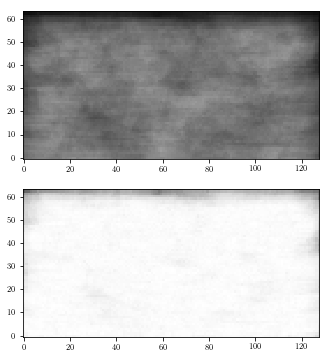

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(ks.mean(0).T[::-1], vmin=0, vmax=1)
ax[1].imshow(ks.std(0).T[::-1], vmin=0, vmax=0.5)

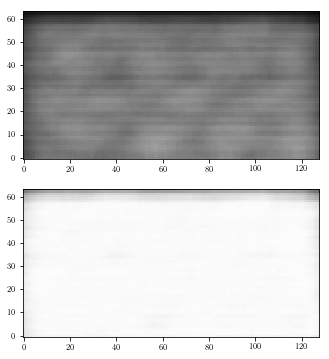

In [122]:
pdf = torch.distributions.Normal(0, 0.75)
set_seed(42)
ks = []
for i in tqdm(range(100)):
    with torch.no_grad():
        z = pdf.sample((10, 50, 1, 2))
        k, poro, x = generator(z)
        ks.append(x.numpy())
ks = np.concatenate(ks, 0)
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(ks.mean(0).T[::-1], vmin=0, vmax=1)
ax[1].imshow(ks.std(0).T[::-1], vmin=0, vmax=0.5)

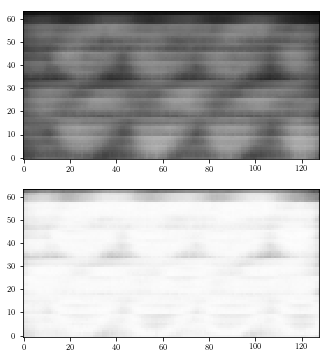

In [127]:
pdf = torch.distributions.Normal(0, 0.5)
set_seed(42)
ks = []
for i in tqdm(range(100)):
    with torch.no_grad():
        z = pdf.sample((10, 50, 1, 2))
        k, poro, x = generator(z)
        ks.append(x.numpy())
ks = np.concatenate(ks, 0)
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(ks.mean(0).T[::-1], vmin=0, vmax=1)
ax[1].imshow(ks.std(0).T[::-1], vmin=0, vmax=0.5)

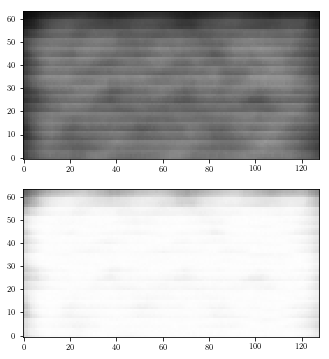

In [128]:
pdf = torch.distributions.Normal(0, 2)
set_seed(42)
ks = []
for i in tqdm(range(100)):
    with torch.no_grad():
        z = pdf.sample((10, 50, 1, 2))
        k, poro, x = generator(z)
        ks.append(x.numpy())
ks = np.concatenate(ks, 0)
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(ks.mean(0).T[::-1], vmin=0, vmax=1)
ax[1].imshow(ks.std(0).T[::-1], vmin=0, vmax=0.5)

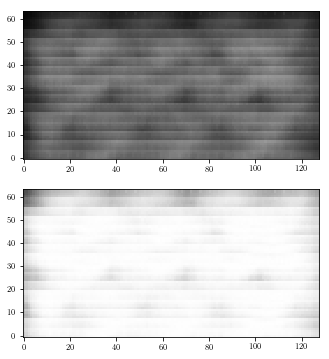

In [129]:
pdf = torch.distributions.Normal(0, 4)
set_seed(42)
ks = []
for i in tqdm(range(100)):
    with torch.no_grad():
        z = pdf.sample((10, 50, 1, 2))
        k, poro, x = generator(z)
        ks.append(x.numpy())
ks = np.concatenate(ks, 0)
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(ks.mean(0).T[::-1], vmin=0, vmax=1)
ax[1].imshow(ks.std(0).T[::-1], vmin=0, vmax=0.5)

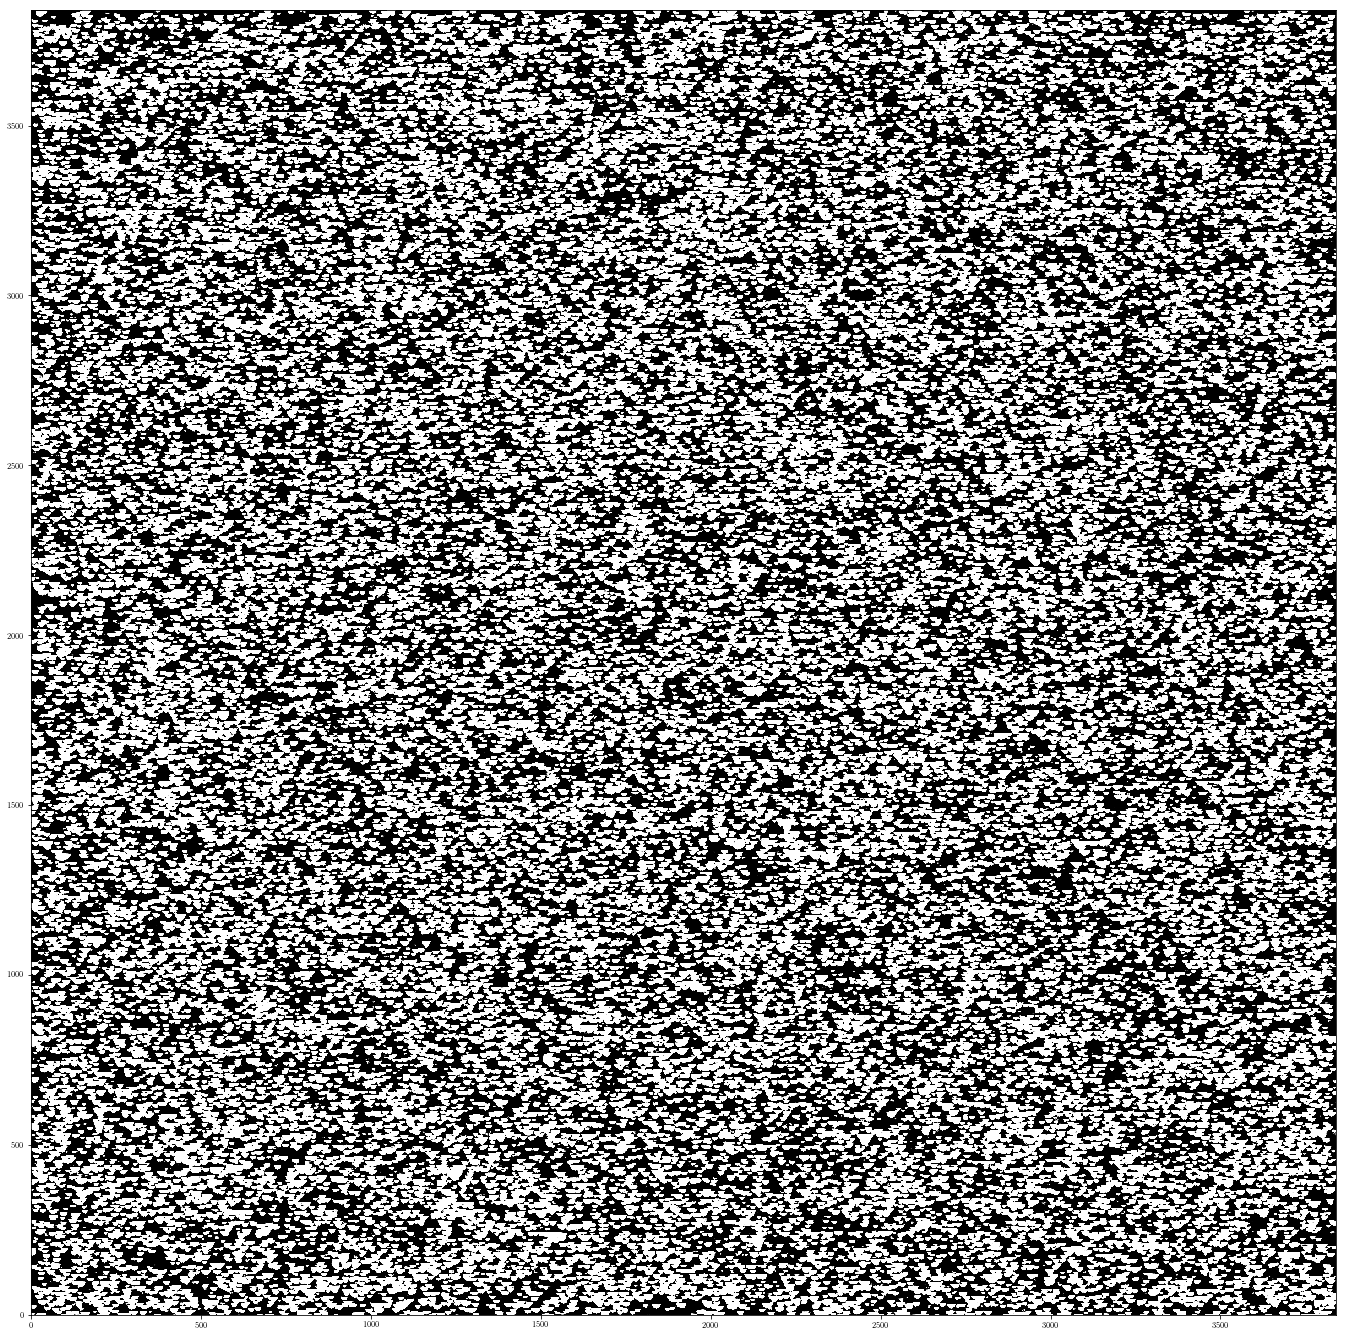

In [168]:
pdf = torch.distributions.Normal(0, 1.0)
z = pdf.sample((1, 50, 60, 60))
with torch.no_grad():
    k, poro, x = generator(z)
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
ax.imshow(x[0].numpy().T[::-1], vmin=0, vmax=1)

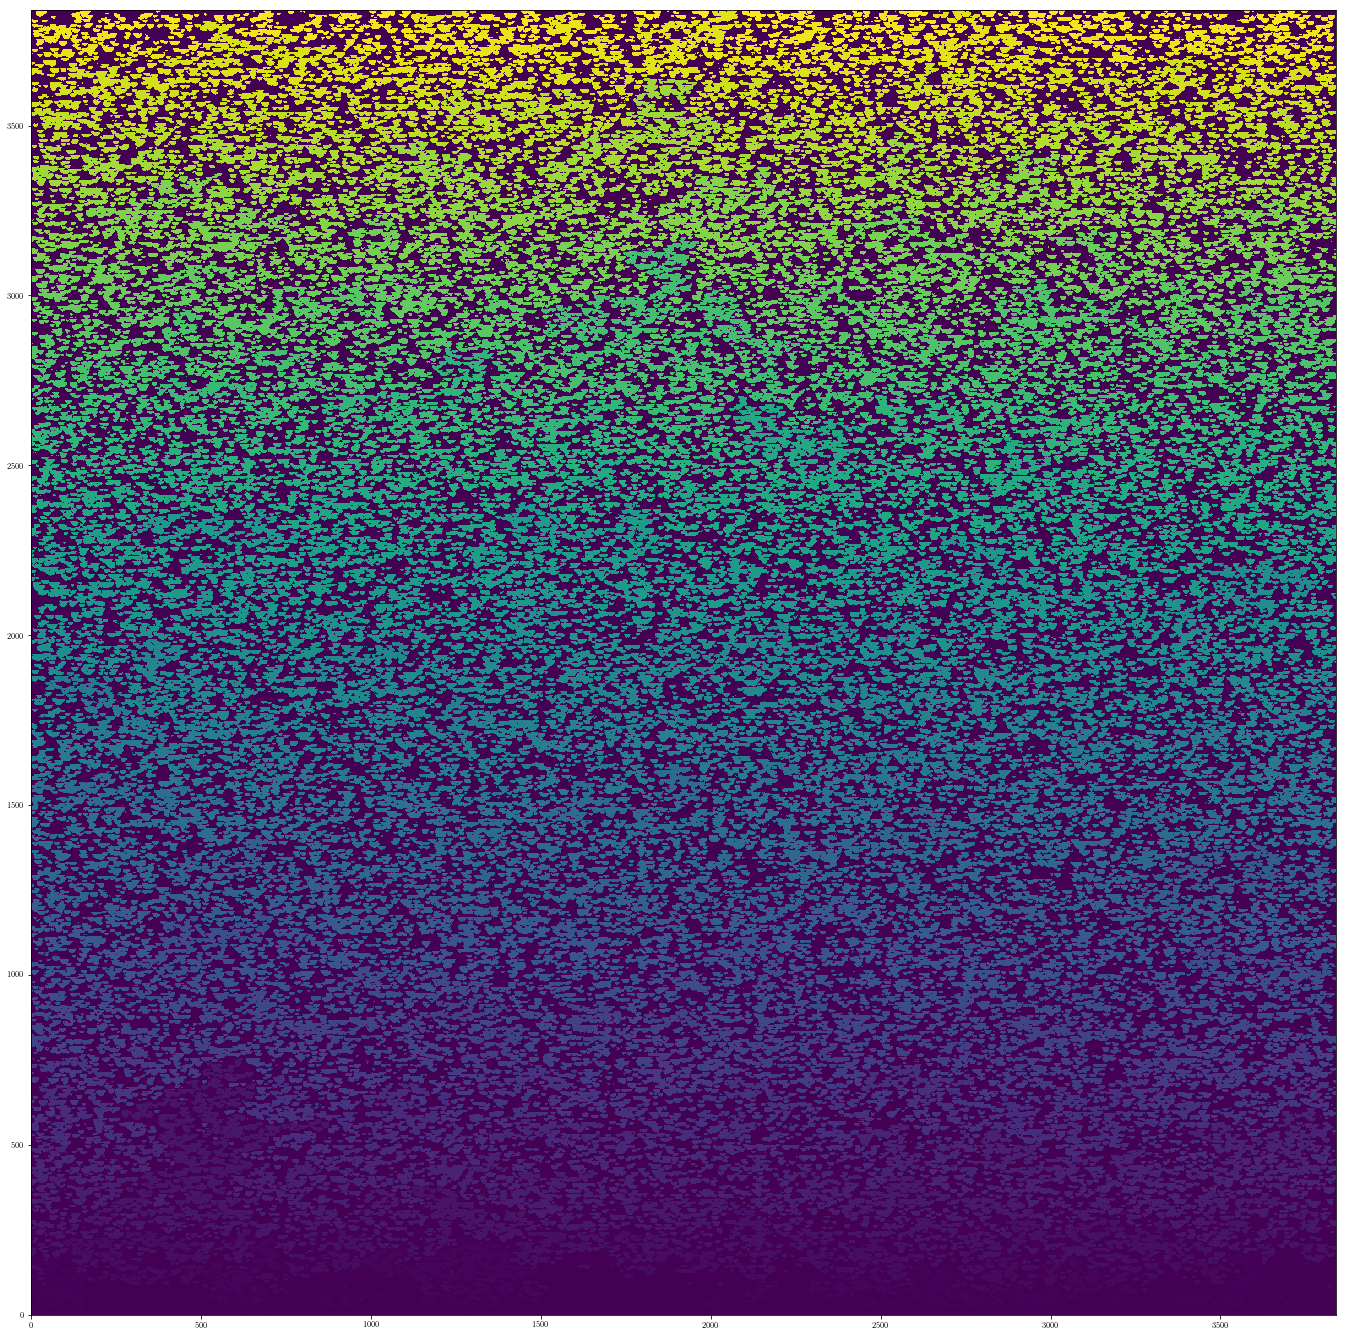

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
ax.imshow(measure.label(np.where(x[0].numpy().T[::-1]>0.5, 1, 0)), cmap="viridis")

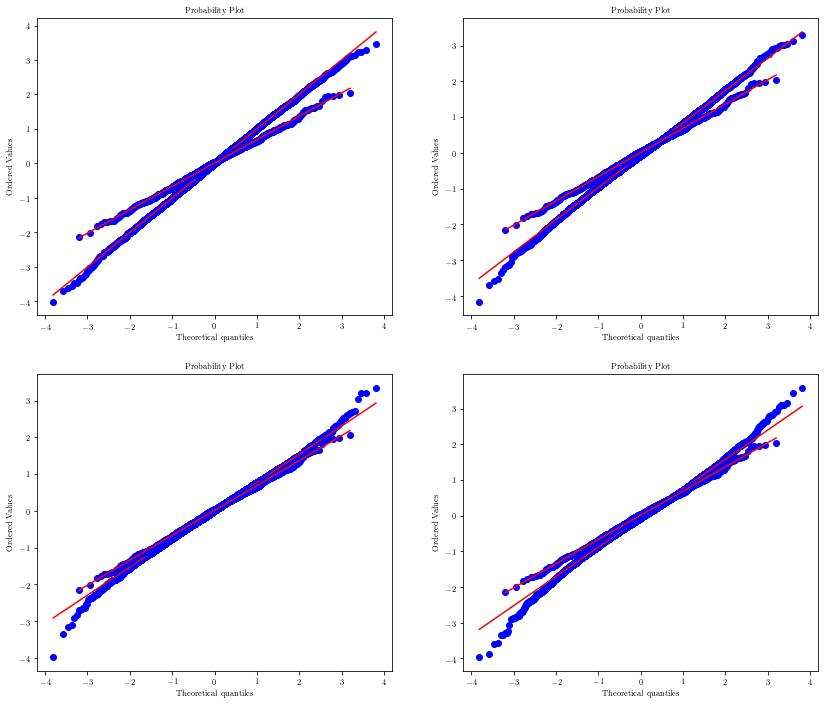

In [160]:
from scipy import stats

pdf = torch.distributions.Normal(0,  0.7)
z_biased = pdf.sample((1000, ))
ax4 = plt.subplot(int("22"+str(1)))
res = stats.probplot(unc_zs[0:100, 0, 1].reshape(100*100), plot=plt)
res =  stats.probplot(z_biased, plot=plt)
for i in range(1, 4):
    ax4 = plt.subplot(int("22"+str(i+1)))
    res = stats.probplot(all_zs[i-1][0][:, 1].reshape(100*100), plot=plt)
    res =  stats.probplot(z_biased, plot=plt)

In [85]:
import torch

In [168]:
dist = torch.distributions.MultivariateNormal(torch.zeros(100), torch.eye(100))
dist.sample()

tensor([-2.7006e+00,  1.2763e+00,  1.0327e+00, -9.7939e-01, -1.7046e+00,
         1.1712e-01, -4.1545e-02,  2.4444e+00,  1.1993e+00, -5.6718e-01,
        -9.9981e-01,  1.4402e+00,  1.6521e-01, -2.2924e-01,  3.5475e-01,
        -3.0298e-01,  1.3472e+00,  2.9762e-01,  4.7561e-01,  8.6872e-01,
         1.5682e-01,  4.7909e-01, -2.6916e-01, -2.6180e-01, -2.9614e-01,
        -1.0109e+00, -3.4393e-02,  7.3209e-01,  1.0051e+00, -1.9917e-01,
        -9.3814e-01, -4.6349e-01, -1.6374e+00,  9.9350e-01, -1.5326e+00,
        -1.6661e-01, -2.2922e-01, -6.7471e-01,  8.1428e-01,  1.0563e+00,
        -9.3251e-01, -7.8330e-01,  7.5782e-01, -4.3484e-01, -2.1468e+00,
         1.4404e-01, -4.1604e-01,  1.2864e+00, -1.3061e+00,  1.0572e+00,
        -1.3205e+00, -1.1617e+00, -5.6351e-02,  3.7942e-01, -2.1356e-01,
        -4.1151e-01,  2.8365e-01,  9.6568e-01, -5.1236e-01, -7.2940e-01,
         1.7705e+00,  2.4579e+00,  6.6368e-01, -1.1360e+00,  6.6229e-01,
        -5.9448e-01,  1.2854e+00,  1.2303e+00,  1.0

In [175]:
logprobs = []
for i in range(3):
    zs_1 = torch.from_numpy(all_zs[i][0][:, 1].reshape(100, 100))
    logProb = [dist.log_prob(x).item() for x in zs_1]
    logprobs.append(logProb)

In [176]:
unc_zs_1 = torch.from_numpy(unc_zs[:, 0, 1].reshape(1000, 100))
unc_logProb = [dist.log_prob(x) for x in unc_zs_1]

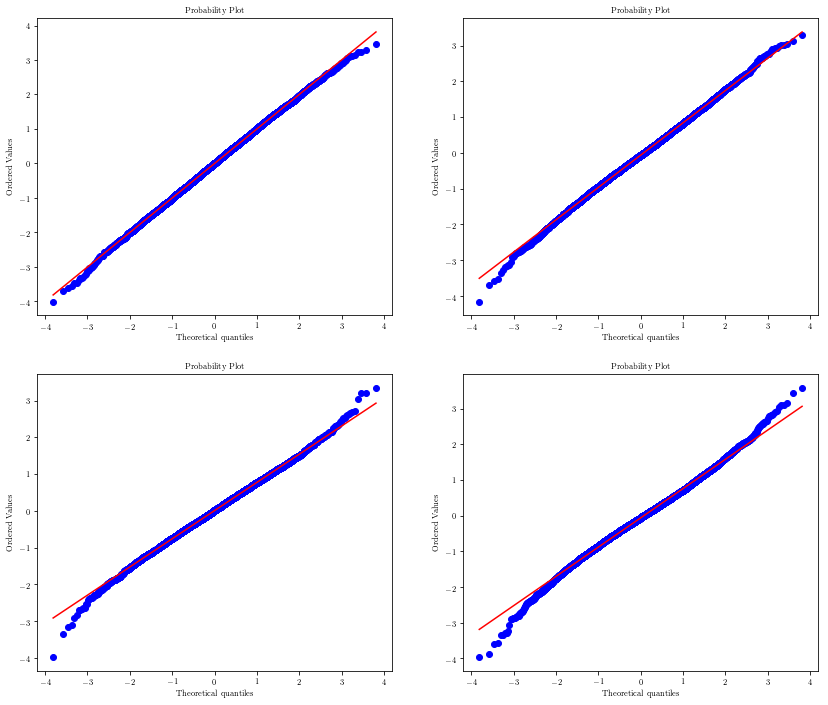

In [160]:
from scipy import stats

ax4 = plt.subplot(int("22"+str(1)))
res = stats.probplot(unc_zs[0:100, 0, 1].reshape(100*100), plot=plt)
for i in range(1, 4):
    ax4 = plt.subplot(int("22"+str(i+1)))
    res = stats.probplot(all_zs[i-1][0][:, 1].reshape(100*100), plot=plt)